In [1]:
import numpy as np
from numpy import array
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU,Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [2]:
import tensorflow as tf
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

filename = "Dataset/train/annotations_train1.txt"
doc = load_doc(filename)
print(doc[:300])

VizWiz_train_00000000.jpg,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS THE NET WEIGHT TOO.
VizWiz_train_00000000.jpg,A green and white plastic condiment bottle containing Basil leaves.
VizWiz_train_00000000.jpg,Quality issues are too severe to recognize visual content.
VizWiz_train_00000000.jpg,A bo


In [4]:
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split(',')
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        
        if image_id[0] == 'V':
            with open('Dataset/train/img_ids.txt', 'a') as f:
                f.write(image_id + '\n')
                f.close()

        image_desc = ' '.join(image_desc)
  
        if image_id not in mapping:
            mapping[image_id] = list()
     
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(doc)


def load_descriptions_val(doc):
    mapping = dict()

    for line in doc.split('\n'):
        tokens = line.split(',')
        if len(line) < 2:
            continue
     
        image_id, image_desc = tokens[0], tokens[1:]
      
        image_id = image_id.split('.')[0]
        
        if image_id[0] == 'V':
            with open('Dataset/val/img_ids.txt', 'a') as f:
                f.write(image_id + '\n')
                f.close()

     
        image_desc = ' '.join(image_desc)
     
        if image_id not in mapping:
            mapping[image_id] = list()
   
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(doc)


In [5]:
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
        
            desc = desc.split()
        
            desc = [word.lower() for word in desc]
            
            desc = [w.translate(table) for w in desc]
       
            desc = [word for word in desc if len(word)>1]
           
            desc = [word for word in desc if word.isalpha()]
            
            desc_list[i] =  ' '.join(desc)


clean_descriptions(descriptions)

In [6]:
print(descriptions['VizWiz_train_00000004'])

['box for garden light rests in someones lap', 'box containing information about solar garden light product', 'garden book is sitting on persons lap', 'box for solar garden light laying on someones lap', 'blue and yellow box with lights for the garden inside']


In [7]:

def to_vocabulary(descriptions):
   
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 11000


In [8]:

def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'Dataset/train/descriptions.txt')

In [9]:

def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
   
    for line in doc.split('\n'):
       
        if len(line) < 1:
            continue
       
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

filename = 'Dataset/train/img_ids.txt'
train = load_set(filename)


In [10]:
images = 'Dataset/train/data'

In [11]:
train_images_file = 'Dataset/train/img_ids.txt'
train_images = open(train_images_file, 'r').read().strip().split('\n')
train_img = []

for i in train_images: 
    train_img.append('Dataset/train/data/' + i + '.jpg')

In [12]:
# Below file conatains the names of images to be used in test data
# test_images_file = '../../storage/image_caption/dataset/TextFiles/Flickr_8k.testImages.txt'

# # Read the validation image names in a set# Read the test image names in a set
# test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# # Create a list of all the test images with their full path names
# test_img = []

# for i in img: # img is list of full path names of all images
#     if i[len(images):] in test_images: # Check if the image belongs to test set
#         test_img.append(i) # Add it to the list of test images

In [13]:

def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
     
        if image_id in dataset:
    
            if image_id not in descriptions:
                descriptions[image_id] = list()
    
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

train_descriptions = load_clean_descriptions('Dataset/train/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=8000


In [14]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [15]:
model = InceptionV3(weights='imagenet')

In [16]:
model_new = Model(model.input, model.layers[-2].output)

In [17]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [18]:
# # Call the funtion to encode all the train images
# # This will take a while on CPU - Execute this only once
# start = time()
# encoding_train = {}
# count = 0
# for img in train_img:
#     encoding_train[img[len(images):]] = encode(img)
#     if count % 100 == 0:
#         print(img[-12:-4])
#     count += 1
# print("Time taken in seconds =", time()-start)

# # Save the bottleneck train features to disk
# with open("Dataset/train/encoded_train_images.pkl", "wb") as encoded_pickle:
#     dump(encoding_train, encoded_pickle)

In [19]:
# # Call the funtion to encode all the test images - Execute this only once
# start = time()
# encoding_test = {}
# for img in test_img:
#     encoding_test[img[len(images):]] = encode(img)
# print("Time taken in seconds =", time()-start)

In [20]:
# # Save the bottleneck test features to disk
# with open("../../storage/image_caption/dataset/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_test, encoded_pickle)

In [21]:
train_features = load(open("Dataset/train/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=8000


In [22]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

40000

In [23]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

40000

In [24]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 11000 -> 2513


In [25]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [26]:
vocab_size = len(ixtoword) + 1 
vocab_size

2514

In [27]:

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 81


In [28]:

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
  
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos['/' + key + '.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
         
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [29]:

glove_dir = 'Dataset/'
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [30]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [31]:
embedding_matrix.shape

(2514, 200)

In [32]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, return_sequences=True)(se2)

se4 = LSTM(512)(se3)
decoder1 = Add()([fe2, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 81)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 81, 200)      502800      ['input_3[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout_1 (Dropout)            (None, 81, 200)      0           ['embedding[0][0]']              
                                                                                            

In [34]:
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

In [35]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [36]:
epochs = 20
number_pics_per_batch = 20
steps = len(train_descriptions)//number_pics_per_batch

In [37]:
# for i in range(epochs):
#     generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
# model.save('./model_weights/model3_20' + '.h5')    

In [38]:
# for i in range(epochs):
#     generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [39]:
# #model.optimizer.lr = 0.0001
# epochs = 10
# number_pics_per_bath = 16
# steps = len(train_descriptions)//number_pics_per_bath

In [40]:
# for i in range(epochs):
#     generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
# model.save('./model_weights/model2_30.h5')

In [41]:
with open("Dataset/val/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

images = 'Dataset/val/data'

model = load_model('./model_weights/model_best_20.h5')

In [42]:
filename = "Dataset/val/annotations_val.txt"
doc = load_doc(filename)
print(doc[:300])

descriptions = load_descriptions_val(doc)
print('Loaded: %d ' % len(descriptions))

clean_descriptions(descriptions)

vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

save_descriptions(descriptions, 'Dataset/val/descriptions.txt')


filename = 'Dataset/val/img_ids.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

images = 'Dataset/val/data'


test_images_file = 'Dataset/val/img_ids.txt'
test_images = open(test_images_file, 'r').read().strip().split('\n')

test_img = []

for i in test_images:

    test_img.append('Dataset/val/data/' + i + '.jpg') 

test_descriptions = load_clean_descriptions('Dataset/val/descriptions.txt', test)
print('Descriptions: val=%d' % len(test_descriptions))

image,caption
VizWiz_val_00000000.jpg,A computer screen shows a repair prompt on the screen.
VizWiz_val_00000000.jpg,a computer screen with a repair automatically pop up
VizWiz_val_00000000.jpg,partial computer screen showing the need of repairs
VizWiz_val_00000000.jpg,Part of a computer monitor sho
Loaded: 7827 
Original Vocabulary Size: 10962
Dataset: 7750
Descriptions: val=7750


In [43]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

/VizWiz_val_00004484.jpg


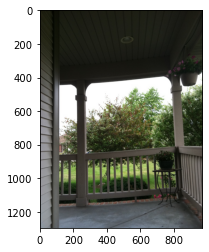

Prediction : large white and white dog with white pants around its neck and his shoes sticking out from the door
BLEU score: 0.3157894736842105
/VizWiz_val_00002252.jpg


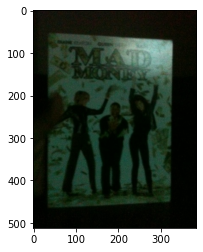

Prediction : movie movie movie case with picture of people on it
BLEU score: 0.6333861926251716
/VizWiz_val_00005311.jpg


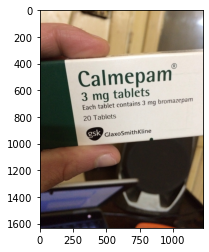

Prediction : person holding box of tablets in their hand
BLEU score: 0.875
/VizWiz_val_00003378.jpg


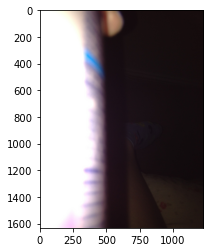

Prediction : quality issues are too severe to recognize visual content
BLEU score: 1.0


In [47]:

Z = [4484,2252, 5311, 3378]
num = len(test_descriptions)

bleu_scores = []
for z in Z:
    pic = '/VizWiz_val_0000' + str(z) + '.jpg'
    print(pic)
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Prediction :",greedySearch(image))
    
    references = []
    for desc in test_descriptions[pic[1:-4]]:
        reference = desc.split(' ')
        del reference[0]
        del reference[-1]
        references.append(reference)
        
    candidate = greedySearch(image).split(' ')  
#     print(references)
#     print(candidate)

    score = sentence_bleu(references, candidate, smoothing_function=SmoothingFunction().method1, weights=(1,0,0,0))
    print('BLEU score:', score)
    bleu_scores.append(score)

In [45]:
print(sum(bleu_scores)/len(bleu_scores))

0.5655219582886728
